# SlateFree:  AISTATS'24 submission

Copyright 2024 Anonymous Authors of the AISTATS'24 submission "SlateFree: a Model-Free Value Decomposition for Sequential Slate Recommendations"

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [ ]:
import numpy as np
import math
from scipy.optimize import linprog
import warnings
import time
import pandas as pd
import matplotlib.pyplot as plt
#
warnings.filterwarnings("ignore")

We first build the MDP recommender and derive its solution with Policy and Value Iteration.

In [ ]:
# Number of recommended items
N=3
# Size of library
K=10
# Discount factor lambda for the Value-function
lam = 0.85

Select user type:
- **User1** has fixed retention probability $a$ to select one of the recommended items uniformly at random with probability $a/N$. With probability $1-a$ the slate is rejected and the user choses at random one from the $K$ librabry items with probability vector $p0$ (defined later).
- **User2** (*) has again retention probability $a$, but will never select items belonging to  a set XX, neither in the recommendation slate, nor in $p0$. In the case that the recommendation slate only has items from set XX, the user goes to $p0$.
- **User3** (*) will always select from the recommendation slate, if at least one item from set YY is included, otherwise will go to $p0$.

(*) only for RL, not treated by MDP methods below

In [ ]:
user = 2

Choose the user preference vector $p0$

In [ ]:
# - Choose random p0
#np.random.seed(0)
#p0 = np.random.uniform(0,1,K)
# - or Choose uniform p0
p0 = np.ones(K)
#normalise
p0=p0/np.sum(p0)
#print(p0)

For User-1 and User-2 choose the retention probability.

In [ ]:
# User Retention (click on the recommendation list OR not 1-a)
a = .75

Exclusion set for User2 (same for desirable set for User3)

In [ ]:
XX = list([0,1,8])

Since User2 will never select from XX, we re-determine p0 with exclusions for User2

In [ ]:
p0X=p0.copy()
p0X[XX]=0
# re-normalise
p0X=p0X/np.sum(p0X)

In [ ]:
if user == 1 or user == 3:
    p0in = p0
else:
    p0in = p0X
#print(p0in)

Cost of items (we minimise in this simulation program, so less cost is better)

In [ ]:
#Costs
co = 20*np.ones(K)
co[0] = 5
co[1] = 0
co[-1] = 8 #see if/when the item with between cost is selected
co[-3] = 4
np.random.seed(9)
co+=np.random.uniform(0,4,len(co))
#print(co)

## A. MDP Methods

### A.1 Value Iteration

Given a policy Rn we do value iteration updates. The value iteration function requires as input the maximum number of iterations $T_{max}$ as well as the acceptable error (norm-$\infty$)

In [ ]:
err = 0.001
T_max = 1000

In [ ]:
def ValueIt(K,p0,N,lam,a,err,T_max,user,XX):
    #Unknown value functions
    V_old = np.array(np.zeros(K))
    t = 0
    BIG = 1000000
    diff = BIG
    indic_XX = np.zeros(K)
    indic_XX[XX]=1
    diff_av = 0
    #
    while (diff > err) and (t<T_max) and (np.abs(diff-diff_av) > err):
        t+=1
        if t%100==0:
            print('Iteration:',t)
        Rn = list()
        for j in range(K):
            A_ub= [list(-np.ones(K))]
            b_ub= 0
            A_eq=[np.ones(K)]
            e_j = np.zeros(K)
            e_j[j] = 1
            A_eq.append(e_j)
            b_eq=[[N,0]]
            if user ==1:
                res = linprog(V_old,A_ub,b_ub,A_eq,b_eq,bounds=np.tile([0,1],(K,1)),method='revised simplex')
            Rn.append(list(res.x))
        Rn = np.array(Rn)
        if user==1:
            P = a/N*Rn + (1-a)*np.array(np.tile(np.array(p0),(K,1)))
        elif user==2:
            P = a/N*np.multiply(Rn,1-indic_XX) + np.outer(1-a/N*(Rn@(1-indic_XX)),p0)
        prod = (P@V_old)
        V_new = co + lam*prod
        V_save = V_old
        diff = math.sqrt(np.linalg.norm(V_new-V_old,ord=np.inf))
        diff_av = a*diff+(1-a)*diff_av
        V_old = np.array(list(V_new))
    print("Iterations:",t)
    #
    return [V_new*(1-lam), np.round(Rn,3), diff, V_save*(1-lam)]

In [ ]:
if user ==1:
    v, r, diff, v_old = ValueIt(K,p0in,N,lam,a,err,T_max,user,XX)
    print("V=",np.round(v,4))
    print("R=",r)
    print("Convergence error=",diff)

### A.2 Policy Iteration

The Policy iteration updates recommendation frequencies. The recommendation frequency policy needs initialisation.

In [ ]:
#Initialisation (random)
np.random.seed(99)
Ro = np.random.uniform(0,N,[K,K])
# The self-recommendations get 0 frequency
for j in range(K):
    Ro[j,j]=0
#Normalise so that the row-sum is equal to N
No = np.tile(np.array(np.sum(Ro,axis=1)).transpose(), (K,1))
No = No.transpose()
Ro = np.round(N*np.array([i / j for i, j in zip(Ro, No)]),3)
#print(Ro)

The policy iteration function requires as input the maximum number of iterations $T_{max}$ as well as the acceptable error (norm-$\infty$)

In [ ]:
err2 = 0.001
T_max2 = 100

In [ ]:
def PolicIt(K,p0,lam,a,N,Ro,err,T_max,err2,T_max2,user,XX):
    R_new = Ro
    BIG = 10000
    diff2 = BIG
    t1=0
    indic_XX = np.zeros(K)
    indic_XX[XX]=1
    #
    while (diff2 > err2) and (t1<T_max2):
        t1+=1
        V_old = np.array(np.zeros(K))
        # Policy evaluation (iteration)
        diff = 10
        t=0
        while (diff > err) and (t<T_max):
            t+=1
            if user==1:
                P = a/N*R_new + (1-a)*np.array(np.tile(np.array(p0),(K,1)))
            prod = (P@V_old)
            V_new = co + lam*prod
            diff = math.sqrt(np.linalg.norm(V_new-V_old,ord=np.inf))
            V_old = np.array(list(V_new))
        Rup = list()
        for j in range(K):
            A_ub= [list(-np.ones(K))]
            b_ub= 0
            A_eq=[np.ones(K)]
            e_j = np.zeros(K)
            e_j[j] = 1
            A_eq.append(e_j)
            b_eq=[[N,0]]
            if user==1:
                res = linprog(V_old,A_ub,b_ub,A_eq,b_eq,bounds=np.tile([0,1],(K,1)),method='revised simplex')
            Rup.append(list(res.x))
        Rup = np.array(Rup)
        R_old = R_new.copy()
        R_new = np.round(Rup,4)
        diff2 = math.sqrt(np.linalg.norm(R_new-R_old,ord=np.inf))
    print("Iterations:",t1)
    return [np.round(V_new*(1-lam),4), np.round(R_new,3)]

In [ ]:
if user==1:
    vp, rp = PolicIt(K,p0in,lam,a,N,Ro,err,T_max,err2,T_max2,user,XX)
    print("Vp=",vp)
    print("Rp=",rp)

## B. Vanilla RL Methods

Implementation parameters

In [ ]:
T_epis = 12000 # number of episodes
gamma = 0.004 # learning rate
epsip0 = 0.05 # eps-greedy, exploration part

We can choose between methods: 'min' just applies the standard RL, whereas 'penalty' adds an extra positive penalty when the user does not follow the recommendation.

In [ ]:
method = 'min'
#method = 'penalty'

In [ ]:
if method == 'min':
    PENALTY = 0
elif method == 'penalty':
    PENALTY = 2*np.floor(max(co))
#
print(PENALTY)

0


### B.1 SARSA (On-policy) N=1 dimension

First initialise the Q-table $K\times K$

In [ ]:
# Initialise with arbitrary recommender matrix
BIG = 20000000
Qo = np.eye(K)*BIG
#
for i in range(K):
    if i==K-1:
        Qo[i][0]=2
    else:
        Qo[i][i+1]=2
#print(Qo)

In [ ]:
def RandomChoice(S_old,K,cumulP0):
    S_new = S_old
    while S_new==S_old:
        ran = np.random.uniform(0,1)
        difi = -10
        k=0
        while (difi<0) and (k<K):
            difi = cumulP0[k]-ran
            k+=1
        S_new = k-1
    return S_new

In [ ]:
def behaveN1(user,reco,a,S_old,K,cumulP0,XX):
    accept = 0
    if user ==1:
        #user decision (based on retention "a")
        if np.random.binomial(1,a,1) ==1:
            #print("Follow reco")
            accept+=1
            S_new = reco
        else:
            #print("Random choice")
            S_new = RandomChoice(S_old,K,cumulP0)
    #
    elif user ==2:
        if np.random.binomial(1,a,1) ==1 and (reco not in XX):
            #print("Follow reco")
            accept+=1
            S_new = reco
        else:
            #print("Random choice")
            S_new = RandomChoice(S_old,K,cumulP0)
    #
    elif user==3:
        #user decision based only on whether there is at least one item from XX recommended
        if reco in set(XX):
            #print("Follow reco")
            accept+=1
            S_new = reco
        else:
            #print("Random choice")
            S_new = RandomChoice(S_old,K,cumulP0)
    #
    return S_new, accept

In [ ]:
def SARSA1(epsip0,p0,lam,K,co,a,Qo,T_epis,gamma,XX,user,method,PENALTY):
    # gamma is the learning rate
    # lam is the original discount
    # a is the retention ratio
    #
    # Create view session-lengths for all episodes
    Len = np.random.geometric(1-lam,T_epis)
    S0L = list()
    BIG = 1000000000000
    cumulP0 = np.cumsum(p0)
    cost = list()
    telE=0 #counts episodes
    Q=Qo
    #
    aM = list()
    #
    for El in Len:
        telE+=1 # increase episode index
        telEs=0 # counts steps of an episode
        S0L2 = list() # list of saved episode states
        cc=0 # initialises episode cost
        # STATE
        S_old = np.random.randint(K) # user chooses initial state
        #print("t0=",telE,"S0=",S_old)
        #
        #ACTION epsilon-greedy
        epsip = epsip0 #(Exploration - Exploitation tradeoff)
        #
        if np.random.binomial(1,epsip,1) == 0:
            # Exploit the best strategy
            #print('BEST reco')
            Q_local = Q[S_old].copy()
            Q_local[S_old]=BIG
            reco = np.argmin(Q_local)
            del Q_local
        else:
            #print('RANDOM reco')
            # Explore among others
            reco = np.random.choice(np.delete(list(np.arange(K)),[S_old]))
        #
        #==================================================================
        # The episode starts loopin'
        #
        for tt in range(El):
            #update discounted cost (REWARD)
            cc+=((lam)**telEs)*co[S_old]
            telEs+=1
            #===============================================
            # NEXT STATE S' (specific user behaviour HERE)
            (S_new, accept) = behaveN1(user,reco,a,S_old,K,cumulP0,XX)
            #
            #===============================================
            #NEW ACTION A' (epsilon-greedy action)
            if np.random.binomial(1,epsip,1) ==0:
                #print('BEST reco')
                Q_local = Q[S_new].copy()
                Q_local[S_new]=BIG
                reco_new = np.argmin(Q_local)
                del Q_local
            else:
                #print('RANDOM reco')
                reco_new = np.random.choice(np.delete(list(np.arange(K)),[S_new]))
            ################
            #update Q
            att = gamma#/(math.sqrt(tt+1))
            #print("S_old,reco,S_new,reco_new=",S_old,reco,S_new,reco_new)
            #
            if method=='min':
                Q[S_old,reco]+= att*(co[S_old]+lam*Q[S_new,reco_new]-Q[S_old,reco])
            elif method=='penalty':
                if accept ==1:
                    Q[S_old,reco]+= att*(co[S_old]+lam*Q[S_new,reco_new]-Q[S_old,reco])
                elif accept==0:
                    Q[S_old,reco]+= att*(co[S_old]+PENALTY+lam*Q[S_new,reco_new]-Q[S_old,reco])
            #
            S0L2.append(S_old)
            #
            S_old = S_new
            #
            reco = reco_new
            #
        S0L.append(S0L2)
        cost.append(cc)
    #
    return [cost, Q, S0L]

In [ ]:
############## run-code SARSA1 ##################
tic = time.perf_counter()
if N==1:
    cost, Q, S0L = SARSA1(epsip0,p0in,lam,K,co,a,Qo,T_epis,gamma,XX,user,method,PENALTY)
#
toc = time.perf_counter()
print(f"Runtime: {toc - tic:0.4f} seconds")

Runtime: 0.0001 seconds


In [ ]:
def output1(Q,K):
    print('Policy_N1=',np.argmin(Q,axis=1),'\n')
    kk = 2
    #print('Q[',kk,']',np.round(Q[kk],5),'\n')
    # optimal policy
    PP = np.zeros((K,K))
    for k in range(K):
        Ps  = np.argmin(Q[k])
        PP[k][Ps]=1
    print('Policy_N1=',PP)

In [ ]:
############## print results SARSA1 ##################
if N==1:
    output1(Q,K)

### B.2 Q-learn (off-policy) N=1 dimension

In [ ]:
def QL1(epsip0,p0in,lam,K,co,a,Qo,T_epis,gamma,XX,user,method,PENALTY):
    # gamma is the learning rate
    # lam is the original discount
    # a is the retention ratio
    # q is the desire constraint level
    #
    Len = np.random.geometric(1-lam,T_epis)
    BIG = 10000000000
    S0L = list()
    cumulP0 = np.cumsum(p0)
    cost = list()
    telE=0 #counts episodes
    Q=Qo
    #
    aM =list()
    #
    for El in Len:
        telE+=1
        telEs=0 # counts steps of an episode
        S0L2 = list() # list of episode states
        cc=0 # initialises episode cost
        # STATE
        S_old = np.random.randint(K) # user chooses initial state
        #print("t0=",telE,"S0=",S_old)
        #
        # The episode starts loopin'
        #
        for tt in range(El):
            #update discounted cost (REWARD)
            cc+=((lam)**telEs)*co[S_old]
            telEs+=1
            #
            #ACTION epsilon-greedy
            epsip = epsip0
            if np.random.binomial(1,epsip,1) ==0:
                # Exploit the best strategy
                Q_local = Q[S_old].copy()
                Q_local[S_old]=BIG
                reco = np.argmin((Q_local[S_old]))
                del Q_local
            else:
                # Explore among others
                reco = np.random.choice(np.delete(list(np.arange(K)),[S_old]))
            #
            #=========================================================
            # NEXT STATE S' (specific user behaviour HERE)
            (S_new, accept) = behaveN1(user,reco,a,S_old,K,cumulP0,XX)
            #=========================================================
            #update Q
            att = gamma#/(math.sqrt(tt+1))
            #print("S_old,reco,S_new=",S_old,reco,S_new)
            #
            if method == 'min':
                Q[S_old,reco]+= att*(co[S_old]+lam*min(Q[S_new])-Q[S_old,reco])
            elif method == 'penalty':
                if accept == 1:
                    Q[S_old,reco]+= att*(co[S_old]+lam*min(Q[S_new])-Q[S_old,reco])
                elif accept == 0:
                    Q[S_old,reco]+= att*(co[S_old]+PENALTY+lam*min(Q[S_new])-Q[S_old,reco])
            #
            S0L2.append(S_old)
            #
            S_old = S_new
            #
        S0L.append(S0L2)
        cost.append(cc)
    #
    return [cost, Q, S0L]

In [ ]:
############## run-code QL1 ##################
tic = time.perf_counter()
if N==1:
    cost_Q, Q_Q, S0L_Q = QL1(epsip0,p0in,lam,K,co,a,Qo,T_epis,gamma,XX,user,method,PENALTY)
#
toc = time.perf_counter()
print(f"Runtime: {toc - tic:0.4f} seconds")

Runtime: 0.0001 seconds


In [ ]:
############### print results QL1 ######################
if N==1:
    output1(Q_Q,K)

### B.3: Q-learn slate N>=1 dimensions

First initialize the full Q-table with all possible combinations per state. Here, given a state, the entry of a Q-table represents a different combination without replacement of $N$ items from the library of size $K$.

In [ ]:
import itertools
actions = list()
for x in itertools.combinations(np.arange(K),N):
    actions.append(x)

In [ ]:
print(actions[0])

(0, 1, 2)


In [ ]:
t = 0
indx = {}
for x in actions:
    indx[x]=t
    t+=1

We need to build a Q0 initialisation slate

In [ ]:
#choice between {'binary','random','zero'}
initQ = 'binary'

In [ ]:
BIG = 2000000000000
if initQ == 'binary':
    Q0_slate = np.zeros((K,len(actions)))
    for n in range(K):
        for x in actions:
            if n in x:
                Q0_slate[n][indx[x]] = BIG
elif initQ == 'random':
    #Alternative initialization just random
    np.random.seed(99)
    Q0_slate = np.random.uniform(0,BIG,(K,len(actions)))
elif initQ == 'zero':
    Q0_slate = np.zeros((K,len(actions)))
#
#print(Q0_slate)

In [ ]:
def behaveNN(user,reco,a,S_old,K,cumulP0,XX):
    accept = 0
    if user ==1:
        #user decision (based on retention "a")
        if np.random.binomial(1,a,1) ==1:
            #print("Follow reco")
            accept+=1
            S_new = np.random.choice(list(reco))
        else:
            #print("Random choice")
            S_new = RandomChoice(S_old,K,cumulP0)
    #
    elif user ==2:
        #user decision based on retention and if there is one item not in XX
        if np.random.binomial(1,a,1) ==1 and (len(set(reco).intersection(set(np.arange(K))-(set(XX))))>0):
            #print("Follow reco")
            accept+=1
            S_new = np.random.choice(list(set(reco).intersection(set(np.arange(K))-(set(XX)))))
        else:
            #print("Random choice")
            S_new = RandomChoice(S_old,K,cumulP0)
    #
    elif user==3:
        #user decision based only on whether there is at least one item from XX recommended
        if len(set(reco).intersection(set(XX)))>0:
            #print("Follow reco")
            accept+=1
            S_new = np.random.choice(reco)
        else:
            #print("Random choice")
            S_new = RandomChoice(S_old,K,cumulP0)
    #
    return S_new, accept

In [ ]:
def QLN(epsip0,p0in,lam,K,co,a,Qo,T_epis,gamma,XX,user,method,PENALTY):
    # gamma is the learning rate
    # lam is the original discount
    # a is the retention ratio
    # q is the desire constraint level
    #
    Len = np.random.geometric(1-lam,T_epis)
    BIG = 10000000000
    T0 = .01
    S0L = list()
    cumulP0 = np.cumsum(p0)
    cost = list()
    telE=0 #counts episodes
    Q=Qo.copy()
    #
    for El in Len:
        #print('LENGTH=',El)
        telE+=1
        telEs=0 # counts steps of an episode
        S0L2 = list() # list of episode states
        cc=0 # initialises episode cost
        epsip = epsip0 #exploration
        # STATE
        S_old = np.random.randint(K) # user chooses initial state
        #print("t0=",telE,"S0=",S_old)
        #
        # The episode starts loopin'
        #
        for tt in range(El):
            #update discounted cost (REWARD)
            cc+=((lam)**telEs)*co[S_old]
            telEs+=1
            #
            #ACTION epsilon-greedy
            if np.random.binomial(1,epsip,1) ==0:
                # Exploit the best strategy; do not account for batches including S_old
                #print('BEST strategy')
                Q_local = Q[S_old].copy()
                for x in actions:
                    if S_old in x:
                        Q_local[indx[x]]=BIG
                reco = list(indx.keys())[list(indx.values()).index(np.argmin((Q_local)))]
                del Q_local
            else:
                #print('Explore')
                indx_cp = list(indx.values()).copy()
                for x in actions:
                    if S_old in x:
                        indx_cp.remove(indx[x])
                reco = list(indx.keys())[list(indx.values()).index(np.random.choice(indx_cp))]
            #
            #=========================================================
            # NEXT STATE S'
            #
            (S_new, accept) = behaveNN(user,reco,a,S_old,K,cumulP0,XX)
            #=========================================================
            #update Q
            att = gamma#/(math.sqrt(tt+1))
            #print("S_old,reco,S_new=",S_old,reco,S_new)
            #
            S0L2.append(S_old)
            #
            if method=='min':
                Q[S_old,indx[reco]]+= att*(co[S_old]+lam*min(Q[S_new])-Q[S_old,indx[reco]])
            elif method=='penalty':
                # Option to charge extra PENALTY if accept=0
                if accept==1:
                    Q[S_old,indx[reco]]+= att*(co[S_old]+lam*min(Q[S_new])-Q[S_old,indx[reco]])
                else:
                    Q[S_old,indx[reco]]+= att*(co[S_old]+PENALTY+lam*min(Q[S_new])-Q[S_old,indx[reco]])
            #
            S0L2.append(S_old)
            #
            S_old = S_new
            #
        S0L.append(S0L2)
        cost.append((1-lam)*cc)
    #
    return [cost, Q, S0L]

Now run the method: selection choices \{min,penalty\}

In [ ]:
############## run-code QLN ##################
tic = time.perf_counter()
#
cost_Q, Q_Q, S0L_Q = QLN(epsip0,p0in,lam,K,co,a,Q0_slate,T_epis,gamma,XX,user,method,PENALTY)
#
toc = time.perf_counter()
#
runtimeC = toc-tic
print(f"Runtime: {runtimeC:0.4f} seconds")

Runtime: 10.0026 seconds


In [ ]:
def outputN(Q,K,indx):
    BIG = 1000000000000
    #kk = 2
    #print('Q[',kk,']',np.round(Q[kk],5),'\n')
    # optimal policy
    PP = np.zeros((K,K))
    Best_action = list()
    for k in range(K):
        slateK = np.argmin(Q[k])
        bk = list(indx.keys())[list(indx.values()).index(slateK)]
        Best_action.append(bk)
        PP[k][list(bk)] = 1
    print('Best_slate=',Best_action,'\n')
    print('Policy_NN=',PP)

In [ ]:
############### print results QLN ######################
outputN(Q_Q,K,indx)

Best_slate= [(2, 6, 8), (3, 4, 7), (0, 1, 6), (0, 8, 9), (5, 7, 9), (0, 2, 7), (0, 1, 8), (2, 6, 8), (1, 5, 6), (0, 2, 3)] 

Policy_NN= [[0. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]


Plot cost over Episodes

In [ ]:
# Step 1.Apply smoothing (if no smoothing: window=1)
window = 200 #half window

In [ ]:
def smooth(cost,window,T_epis):
    smooth_cost = list()
    for t in range(T_epis)[window+1:T_epis-window-1]:
        smooth_cost.append(np.sum(cost[t-window:t+window])/2/window)
    #
    return smooth_cost

In [ ]:
smooth_cost_Q = smooth(cost_Q,window,T_epis)
#

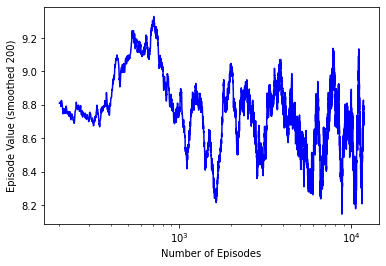

In [ ]:
# Step 2.Plot raw discounted cost over episodes
plt.plot(np.arange(T_epis)[window+1:T_epis-window-1],np.array(smooth_cost_Q),'b')
plt.xlabel('Number of Episodes')
plt.ylabel("Episode Value (smoothed {})".format(window))
plt.xscale('log')
#plt.savefig('QN_User2_200K_smooth200.png')

### B.4: SARSA slate N>=1 dimensions

In [ ]:
def SARSAN(epsip0,p0in,lam,K,co,a,Qo,T_epis,gamma,XX,user,method,PENALTY):
    # gamma is the learning rate
    # lam is the original discount
    # a is the retention ratio
    # q is the desire constraint level
    #
    Len = np.random.geometric(1-lam,T_epis)
    BIG = 10000000000
    T0 = .01
    S0L = list()
    cumulP0 = np.cumsum(p0)
    cost = list()
    telE=0 #counts episodes
    Q=Qo.copy()
    #
    for El in Len:
        #print('LENGTH=',El)
        telE+=1
        if telE%10000 ==0:
            print('episode:',telE)
        telEs=0 # counts steps of an episode
        S0L2 = list() # list of episode states
        cc=0 # initialises episode cost
        epsip = epsip0 #exploration
        # STATE
        S_old = np.random.randint(K) # user chooses initial state
        #print("t0=",telE,"S0=",S_old)
        #
        #ACTION epsilon-greedy
        if np.random.binomial(1,epsip,1) ==0:
            # Exploit the best strategy; do not account for batches including S_old
            #print('BEST strategy')
            Q_local = Q[S_old].copy()
            for x in actions:
                if S_old in x:
                    Q_local[indx[x]]=BIG
            reco = list(indx.keys())[list(indx.values()).index(np.argmin((Q_local)))]
            del Q_local
        else:
            #print('Explore')
            indx_cp = list(indx.values()).copy()
            for x in actions:
                if S_old in x:
                    indx_cp.remove(indx[x])
            reco = list(indx.keys())[list(indx.values()).index(np.random.choice(indx_cp))]
            #
        #==================================================
        # The episode starts loopin'
        #
        for tt in range(El):
            #update discounted cost (REWARD)
            cc+=((lam)**telEs)*co[S_old]
            telEs+=1
            #
            #=========================================================
            # NEXT STATE S'
            #
            (S_new, accept) = behaveNN(user,reco,a,S_old,K,cumulP0,XX)
            #=========================================================
            #
            # NEW ACTION epsilon-greedy
            if np.random.binomial(1,epsip,1) == 0:
                # Exploit the best strategy; do not account for batches including S_new
                #print('BEST strategy')
                Q_local = Q[S_new].copy()
                for x in actions:
                    if S_new in x:
                        Q_local[indx[x]]=BIG
                reco_new = list(indx.keys())[list(indx.values()).index(np.argmin((Q_local)))]
                del Q_local
            else:
                #print('Explore')
                indx_cp = list(indx.values()).copy()
                for x in actions:
                    if S_new in x:
                        indx_cp.remove(indx[x])
                reco_new = list(indx.keys())[list(indx.values()).index(np.random.choice(indx_cp))]
            #
            #=========================================================
            #
            #update Q
            att = gamma#/(math.sqrt(tt+1))
            #print("S_old,reco,S_new=",S_old,reco,S_new)
            #
            S0L2.append(S_old)
            #
            if method=='min':
                Q[S_old,indx[reco]]+= att*(co[S_old]+lam*Q[S_new,indx[reco_new]]-Q[S_old,indx[reco]])
            elif method=='penalty':
                # Option to charge extra PENALTY if accept=0
                if accept==1:
                    Q[S_old,indx[reco]]+= att*(co[S_old]+lam*Q[S_new,indx[reco_new]]-Q[S_old,indx[reco]])
                else:
                    Q[S_old,indx[reco]]+= att*(co[S_old]+PENALTY+lam*Q[S_new,indx[reco_new]]-Q[S_old,indx[reco]])
            #
            S0L2.append(S_old)
            #
            S_old = S_new
            #
            reco = reco_new
            #
        S0L.append(S0L2)
        cost.append((1-lam)*cc)
    #
    return [cost, Q, S0L]

In [ ]:
############## run-code QLN ##################
tic = time.perf_counter()
#
cost_SARN, Q_SARN, S0L_SARN = QLN(epsip0,p0in,lam,K,co,a,Q0_slate,T_epis,gamma,XX,user,method,PENALTY)
#
toc = time.perf_counter()
#
runtimeC = toc-tic
print(f"Runtime: {runtimeC:0.4f} seconds")

Runtime: 9.7434 seconds


In [ ]:
############### print results QLN ######################
outputN(Q_SARN,K,indx)

Best_slate= [(2, 3, 7), (0, 3, 4), (0, 4, 6), (0, 4, 5), (3, 5, 9), (1, 3, 7), (5, 7, 9), (1, 4, 8), (0, 2, 9), (1, 6, 7)] 

Policy_NN= [[0. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]]


In [ ]:
smooth_cost_SARN = smooth(cost_SARN,window,T_epis)
#

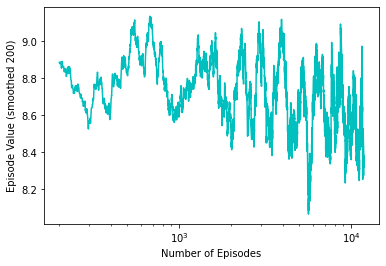

In [ ]:
# Step 2.Plot raw discounted cost over episodes
plt.plot(np.arange(T_epis)[window+1:T_epis-window-1],np.array(smooth_cost_SARN),'c')
plt.xlabel('Number of Episodes')
plt.ylabel("Episode Value (smoothed {})".format(window))
plt.xscale('log')
#plt.savefig('SARSAN_User2_200K_smooth200.png')

## C. SlateFree

### C.1 SlateFree-Q with item frequencies (N>=1)

In [ ]:
def Explore(N,K,S):
    reco = []
    for n in range(N):
        ch = list(np.arange(K))
        reco_plus = reco+[S]
        ch = np.delete(ch,reco_plus)
        add = np.random.choice(ch)
        reco = reco+[add]
        del ch
    return reco

In [ ]:
def QL_SlateFree(N,epsip0,p0in,lam,K,co,a,Qo_item,T_epis,gamma,XX,user,method,PENALTY):
    # N >= 1 is the number of recommendations
    # gamma is the learning rate
    # lam is the original discount
    # a is the retention ratio
    # q is the desire constraint level
    #
    Len = np.random.geometric(1-lam,T_epis)
    BIG = 1000000000
    S0L = list()
    cumulP0 = np.cumsum(p0)
    cost = list()
    telE=0 #counts episodes
    Q=Qo_item.copy()
    #
    #
    for El in Len:
        telE+=1
        telEs=0 # counts steps of an episode
        S0L2 = list() # list of episode states
        cc=0 # initialises episode cost
        # STATE
        S_old = np.random.randint(K) # user chooses initial state
        #print("t0=",telE,"S0=",S_old)
        #
        # The episode starts loopin'
        #
        for tt in range(El):
            #update discounted cost (REWARD)
            cc+=((lam)**telEs)*co[S_old]
            telEs+=1
            #
            #ACTION epsilon-greedy
            epsip = epsip0
            reco=[]
            if np.random.binomial(1,epsip,1) ==0:
                # Exploit the best strategy
                #print('BEST')
                Q_local = Q[S_old].copy()
                #
                for n in range(N):
                    if n==0:
                        Q_local[S_old]=BIG
                        reco=[np.argmin(Q_local)]
                    else:
                        reco.extend([np.argmin(Q_local)])
                    Q_local[np.argmin(Q_local)]=BIG
                del Q_local
            else:
                # Explore among others
                #print('Explore')
                reco = Explore(N,K,S_old)
                #
            #================================================================
            # NEXT STATE S'
            #================================================================
            (S_new, accept) = behaveNN(user,reco,a,S_old,K,cumulP0,XX)
            #
            #================================================================
            #update Q
            att = gamma#/(math.sqrt(tt+1))
            #print("S_old,reco,S_new=",S_old,reco,S_new)
            #
            PARALLUP = 0 #option to test the importance of N parallel updates. Standard value is 0.
            #If e.g. PARALLUP = 2, then the update step below applies to only N-2 items.
            #
            for n in range(N):
                if n>=PARALLUP:
                    if method=='min':
                        Q[S_old,reco[n]]+= att*(co[S_old]+lam*min(Q[S_new])-Q[S_old,reco[n]])
                    elif method=='penalty':
                        # Option to charge extra PENALTY if accept=0
                        if accept==1:
                            Q[S_old,reco[n]]+= att*(co[S_old]+lam*min(Q[S_new])-Q[S_old,reco[n]])
                        else:
                            Q[S_old,reco[n]]+= att*(co[S_old]+PENALTY+lam*min(Q[S_new])-Q[S_old,reco[n]])
         #
            S0L2.append(S_old)
            #
            S_old = S_new
            #
        S0L.append(S0L2)
        cost.append((1-lam)*cc)
        #
    return [cost, Q, S0L]

In [ ]:
Qo_item = Qo
#
#=======================================================
tic = time.perf_counter()
#
cost_Qsf, Q_Qsf, S0L_Qsf = QL_SlateFree(N,epsip0,p0in,lam,K,co,a,Qo_item,T_epis,gamma,XX,user,method,PENALTY)
#
toc = time.perf_counter()

In [ ]:
runtimeI = toc-tic
print(f"Runtime: {runtimeI:0.4f} seconds")

Runtime: 5.8622 seconds


In [ ]:
def outputNitem(Q,K):
    BIG = 1000000000000
    #kk = 2
    #print('Q[',kk,']',np.round(Q[kk],5),'\n')
    # optimal policy
    PP = np.zeros((K,K))
    Best_action = list()
    for k in range(K):
        Qlocal = Q[k].copy()
        bk = list()
        for n in range(N):
            item_opt = np.argmin(Qlocal)
            bk.append(item_opt)
            Qlocal[item_opt]=BIG
        Best_action.append(bk)
        PP[k][list(bk)] = 1
    print('Best_slate=',Best_action,'\n')
    print('Policy_NN=',PP)

In [ ]:
############### print results QL_SlateFree ######################
outputNitem(Q_Qsf,K)

Best_slate= [[9, 3, 4], [7, 0, 8], [7, 1, 8], [1, 7, 0], [7, 0, 1], [7, 1, 8], [1, 7, 0], [9, 0, 8], [3, 6, 9], [7, 1, 8]] 

Policy_NN= [[0. 0. 0. 1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 1. 1. 0.]]


In [ ]:
# Step 1.Apply smoothing (if no smoothing: window=1)
window = 200 #half window
smooth_cost_Qsf = smooth(cost_Qsf,window,T_epis)
#

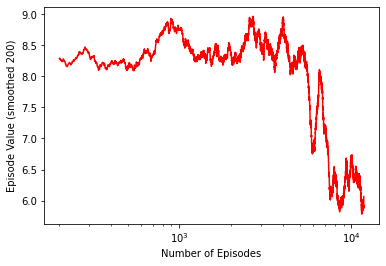

In [ ]:
# Step 2.Plot smoothed discounted cost over episodes
plt.plot(np.arange(T_epis)[window+1:T_epis-window-1],np.array(smooth_cost_Qsf),'r')
plt.xlabel('Number of Episodes')
plt.ylabel("Episode Value (smoothed {})".format(window))
plt.xscale('log')
#plt.savefig('SF_User2_200K_smooth200.png')

### C.2 SlateFree-SARSA with item frequencies N>=1

In [ ]:
def SARSA_SlateFree(N,epsip0,p0in,lam,K,co,a,Qo_item,T_epis,gamma,XX,user,method,PENALTY):
    # gamma is the learning rate
    # lam is the original discount
    # a is the retention ratio
    # q is the desire constraint level
    #
    Len = np.random.geometric(1-lam,T_epis)
    S0L = list()
    BIG = 1000000000000
    cumulP0 = np.cumsum(p0)
    cost = list()
    telE=0 #counts episodes
    Q=Qo_item.copy()
    #
    for El in Len:
        telE+=1
        telEs=0 # counts steps of an episode
        S0L2 = list() # list of episode states
        cc=0 # initialises episode cost
        # STATE
        S_old = np.random.randint(K) # user chooses initial state
        #print("t0=",telE,"S0=",S_old)
        #
        #ACTION epsilon-greedy
        epsip = epsip0 #(Exploration - Exploitation tradeoff)
        #
        if np.random.binomial(1,epsip,1) ==0:
            # Exploit the best strategy
            Q_local = Q[S_old].copy()
            for n in range(N):
                if n==0:
                    Q_local[S_old]=BIG
                    reco=[np.argmin(Q_local)]
                else:
                    reco.extend([np.argmin(Q_local)])
                Q_local[np.argmin(Q_local)]=BIG
            del Q_local
        else:
            # Explore among others
            reco = Explore(N,K,S_old)
            #
        # The episode starts loopin'
        #
        for tt in range(El):
            #update discounted cost (REWARD)
            cc+=((lam)**telEs)*co[S_old]
            telEs+=1
            #================================================================
            # NEXT STATE S'
            #================================================================
            (S_new, accept) = behaveNN(user,reco,a,S_old,K,cumulP0,XX)
            #
            #================================================================
            #NEW ACTION A' (epsilon-greedy action)
            reco_new = list()
            if np.random.binomial(1,epsip,1) ==0:
                # Exploit the best strategy
                Q_local = Q[S_new].copy()
                for n in range(N):
                    if n==0:
                        Q_local[S_new]=BIG
                        reco_new=[np.argmin(Q_local)]
                    else:
                        reco_new.extend([np.argmin(Q_local)])
                    Q_local[np.argmin(Q_local)]=BIG
                del Q_local
            else:
                # Explore among others
                reco_new = Explore(N,K,S_new)
                #
            #=========================================
            #update Q
            att = gamma#/(math.sqrt(tt+1))
            #print("S_old,reco,S_new,reco_new=",S_old,reco,S_new,reco_new)
            #
            #
            sumQmin = 0
            for n in range(N):
                sumQmin+=Q[S_new][reco_new[n]]
            #
            #
            for n in range(N):
                if method=='min' or 'sub':
                    Q[S_old,reco[n]]+= att*(co[S_old]+lam*(sumQmin)/N-Q[S_old,reco[n]])
                elif method=='penalty':
                    # Option to charge extra PENALTY if accept=0
                    if accept==1:
                        Q[S_old,reco[n]]+= att*(co[S_old]+lam*(sumQmin)/N-Q[S_old,reco[n]])
                    else:
                        Q[S_old,reco[n]]+= att*(co[S_old]+PENALTY+lam*(sumQmin)/N-Q[S_old,reco[n]])
            #
            #
            S0L2.append(S_old)
            S_old = S_new
            reco = reco_new
        S0L.append(S0L2)
        cost.append((1-lam)*cc)
    #
    return [cost, Q, S0L]

In [ ]:
Qo_item = Qo
#
#=======================================================
tic = time.perf_counter()
#
cost_SAR, Q_SAR, S0L_SAR = SARSA_SlateFree(N,epsip0,p0in,lam,K,co,a,Qo_item,T_epis,gamma,XX,user,method,PENALTY)
#
toc = time.perf_counter()

In [ ]:
runtimeI = toc-tic
print(f"Runtime: {runtimeI:0.4f} seconds")

Runtime: 5.7085 seconds


In [ ]:
############### print results SlateQ ######################
outputNitem(Q_SAR,K)

Best_slate= [[9, 7, 2], [8, 0, 7], [9, 7, 5], [0, 8, 7], [6, 7, 9], [8, 7, 0], [7, 0, 1], [9, 8, 0], [5, 0, 3], [8, 7, 0]] 

Policy_NN= [[0. 0. 1. 0. 0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]]


In [ ]:
# Step 1.Apply smoothing (if no smoothing: window=1)
#window = 200 #half window
smooth_cost_SAR = smooth(cost_SAR,window,T_epis)
#

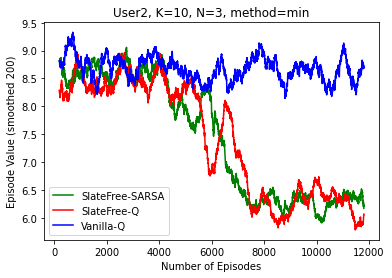

In [ ]:
# Step 2.Plot smooth discounted cost over episodes -- compare with other results
plt.plot(np.arange(T_epis)[window+1:T_epis-window-1],np.array(smooth_cost_SAR),'green',label='SlateFree-SARSA')
plt.plot(np.arange(T_epis)[window+1:T_epis-window-1],np.array(smooth_cost_Qsf),'r',label='SlateFree-Q')
plt.plot(np.arange(T_epis)[window+1:T_epis-window-1],np.array(smooth_cost_Q),'b',label='Vanilla-Q')
plt.xlabel('Number of Episodes')
plt.ylabel("Episode Value (smoothed {})".format(window))
plt.legend(loc='best')
plt.title(title)
#plt.xscale('log')
savePlot4 = savePlot[:-4]+'PLUS.png'
#plt.savefig(savePlot4)

## D. SlateQ

SlateQ comes from reference:

[Ie et al.19] Eugene Ie, Vihan Jain, JingWang, Sanmit Narvekar, Ritesh Agarwal, RuiWu, Heng-Tze Cheng, Tushar Chandra, and Craig Boutilier. "SlateQ: A tractable decomposition for reinforcement learning with recommendation sets." In Proceedings of the Twenty-eighth International Joint Conference on Artificial Intelligence (IJCAI-19), pages 2592–2599, Macau, China, 2019. See arXiv:1905.12767 for a related and expanded paper (with additional material and authors).

For its implementation, we need to provide a user preference matrix, which weights the probability that a user will select an item from the recommendation slate, when viewing item $i$.

In our case we take this choice from some given similarity matrix, because we cannot know the exact profile of the user. In the above [Ie et al.19] paper, the authors assume either a given preference choice matrix irrespective of the user profile, as we do here, or they estimate the choice per user from measurements. Since we do not have this possibility and also because the learning of such parameters is an extra learning process parallel to the Q-learning, we take the fix choice variation. Besides, even such measurements can never be exact, and contain errors. We show that even this arbitrary choice can work for small sizes of library size, but fails to do so, when the size becomes larger.

In [ ]:
#User choice matrix (random with preference on next item)
np.random.seed(99)
U = np.random.uniform(0,1,[K,K])
U+=1*np.eye(K,k=1)
U[K-1][0]+=1
for s in range(K):
    U[s]=U[s]/np.max(U[s])
#print(U)

In [ ]:
def SlateQ(N,epsip0,p0in,lam,K,U,co,a,Qo_item,T_epis,gamma,T,XX,user,method,PENALTY):
    # N >= 1 is the number of recommendations
    # gamma is the learning rate
    # lam is the original discount
    # a is the retention ratio
    # q is the desire constraint level
    #
    Len = np.random.geometric(1-lam,T_epis)
    BIG = 1000000000
    S0L = list()
    cumulP0 = np.cumsum(p0)
    cost = list()
    telE=0 #counts episodes
    Q=Qo_item.copy()
    Prefs = np.ones((K,K))
    #
    for El in Len:
        telE+=1
        telEs=0 # counts steps of an episode
        S0L2 = list() # list of episode states
        cc=0 # initialises episode cost
        # STATE
        S_old = np.random.randint(K) # user chooses initial state
        #print("t0=",telE,"S0=",S_old)
        #
        # The episode starts loopin'
        #
        for tt in range(El):
            #update discounted cost (REWARD)
            cc+=((lam)**telEs)*co[S_old]
            telEs+=1
            #
            #ACTION epsilon-greedy
            epsip = epsip0
            reco=[]
            if np.random.binomial(1,epsip,1) ==0:
                # Exploit the best strategy
                Q_local = Q[S_old].copy()
                for n in range(N):
                    if n==0:
                        Q_local[S_old]=BIG
                        reco=[np.argmin(Q_local)]
                    else:
                        reco.extend([np.argmin(Q_local)])
                    Q_local[np.argmin(Q_local)]=BIG
                del Q_local
            else:
                # Explore among others
                reco = Explore(N,K,S_old)
                #
            #================================================================
            # NEXT STATE S'
            #================================================================
            (S_new, accept) = behaveNN(user,reco,a,S_old,K,cumulP0,XX)
            #
            #================================================================
            # Save the user preferences in a table
            #if telE<T_epis/3:
            #    Prefs[S_old][S_new]+=1
            #================================================================
            #update Q
            att = gamma#/(math.sqrt(tt+1))
            #print("S_old,reco,S_new=",S_old,reco,S_new)
            #
            Q_local = Q[S_new].copy()
            Q_local = Q_local*(np.exp(+T*U[S_new]))
            minsum, densum = 0, 0
            for n in range(N):
                minsum+= min(Q_local)
                densum+=np.exp(+T*U[S_new][np.argmin(Q_local)])
                Q_local[np.argmin(Q_local)]=BIG
            minsum = minsum/densum
            del Q_local
            #
            if method=='min':
                Q[S_old,S_new]+= att*(co[S_old]+lam*minsum-Q[S_old,S_new])
            elif method=='penalty':
                # Option to charge extra PENALTY if accept=0
                if accept==1:
                    Q[S_old,S_new]+= att*(co[S_old]+lam*minsum-Q[S_old,S_new])
                else:
                    Q[S_old,S_new]+= att*(co[S_old]+PENALTY+lam*minsum-Q[S_old,S_new])
            #
            #
            S0L2.append(S_old)
            S_old = S_new
            #
        S0L.append(S0L2)
        cost.append((1-lam)*cc)
    #
    return [cost, Q, S0L]

In [ ]:
Qo_item = Qo
#
T=0.01 #Boltzmann temperature for user choice model
#=======================================================
tic = time.perf_counter()
#
cost_sQ, Q_sQ, S0L_sQ = SlateQ(N,epsip0,p0in,lam,K,U,co,a,Qo_item,T_epis,gamma,T,XX,user,method,PENALTY)
#
toc = time.perf_counter()

In [ ]:
runtimeI = toc-tic
print(f"Runtime: {runtimeI:0.4f} seconds")

Runtime: 7.4525 seconds


In [ ]:
############### print results SlateQ ######################
outputNitem(Q_sQ,K)

Best_slate= [[1, 8, 9], [0, 8, 7], [1, 0, 8], [1, 0, 8], [1, 0, 8], [1, 0, 7], [1, 0, 8], [1, 0, 9], [0, 1, 7], [1, 0, 7]] 

Policy_NN= [[0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [ ]:
# Step 1.Apply smoothing (if no smoothing: window=1)
#window = 200 #half window
smooth_cost_sQ = smooth(cost_sQ,window,T_epis)
#

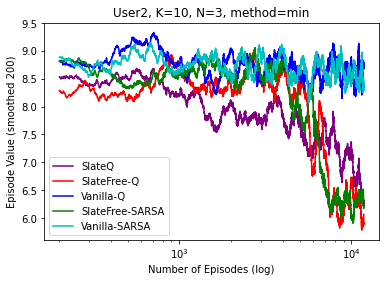

In [ ]:
# Step 2.Plot smooth discounted cost over episodes -- compare with other results
plt.plot(np.arange(T_epis)[window+1:T_epis-window-1],np.array(smooth_cost_sQ),'purple',label='SlateQ')
plt.plot(np.arange(T_epis)[window+1:T_epis-window-1],np.array(smooth_cost_Qsf),'r',label='SlateFree-Q')
plt.plot(np.arange(T_epis)[window+1:T_epis-window-1],np.array(smooth_cost_Q),'b',label='Vanilla-Q')
plt.plot(np.arange(T_epis)[window+1:T_epis-window-1],np.array(smooth_cost_SAR),'green',label='SlateFree-SARSA')
plt.plot(np.arange(T_epis)[window+1:T_epis-window-1],np.array(smooth_cost_SARN),'c',label='Vanilla-SARSA')

plt.xlabel('Number of Episodes (log)')
plt.ylabel("Episode Value (smoothed {})".format(window))
plt.legend(loc='best')
title = "User{}, K={}, N={}, method={}".format(user,K,N,method)
plt.title(title)
plt.xscale('log')
savePlot = "NEW_User_{}_ALL_N{}_K{}_{}_dataValues_PENALTY{}_method{}.png".format(user,N,K,T_epis,PENALTY,method)
#plt.savefig(savePlot)